`KDD2024 Tutorial / A Hands-On Introduction to Time Series Classification and Regression`

# Dictionary-based Time Series Machine Learning in `aeon`

Similar to other subseries extraction algorithms, dictionary approaches identify phase-independent subseries within time series data. These approaches convert each window into a sequence of discrete symbols, commonly referred to as a word. Dictionary methods differentiate themselves by analyzing word frequency, a concept often described as a bag-of-words approach. This process can be summarized as follows:

1. Extracting subseries, or windows, from the time series;
2. Converting each window of real values into a discrete-valued word (a sequence of symbols from a fixed alphabet);
3. Constructing a sparse feature vector based on histograms of word counts; and
4. Finally, applying a machine learning classification method to these feature vectors.

## Table of Contents <a id='toc'></a>

* [Load example data](#load-data)
* [Symbols Approximation Methods](#symbols)
    * [SAX: Symbolic Aggregate approXimation](#sax)
        * [Transforming Time Series To Symbols with SAX](#sax-transform)
    * [SFA: Symbolic Fourier Approximation](#sfa)
        * [Transforming Time Series To Symbols with SFA](#sfa-transform)
* [Bag-of-SFA-Symbols (BOSS)](#boss)
* [Multiple Representations Sequence Miner (MrSQM)](#mrsqm)
* [WEASEL and WEASEL2](#weasel)
* [Performance on the UCR univariate classification datasets](#evaluation)
* [References](#references)

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
from aeon.registry import all_estimators
all_estimators(
    "classifier", filter_tags={"algorithm_type": "dictionary"}, as_dataframe=True
)

,name,estimator
0,BOSSEnsemble,<class 'aeon.classification.dictionary_based._...
1,ContractableBOSS,<class 'aeon.classification.dictionary_based._...
2,MUSE,<class 'aeon.classification.dictionary_based._...
3,OrdinalTDE,<class 'aeon.classification.ordinal_classifica...
4,REDCOMETS,<class 'aeon.classification.dictionary_based._...
5,TemporalDictionaryEnsemble,<class 'aeon.classification.dictionary_based._...
6,WEASEL,<class 'aeon.classification.dictionary_based._...
7,WEASEL_V2,<class 'aeon.classification.dictionary_based._...


In [2]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "dictionary"}, as_dataframe=True
)

,name,estimator


## Load example data <a id='load-data'></a>

In [21]:
from aeon.datasets import load_from_tsfile

X_train_c, y_train_c = load_from_tsfile("./data/KDD_UTSC_TRAIN.ts")
X_test_c, y_test_c = load_from_tsfile("./data/KDD_UTSC_TEST.ts")

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (40, 1, 100)
Test shape: (40, 1, 100)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

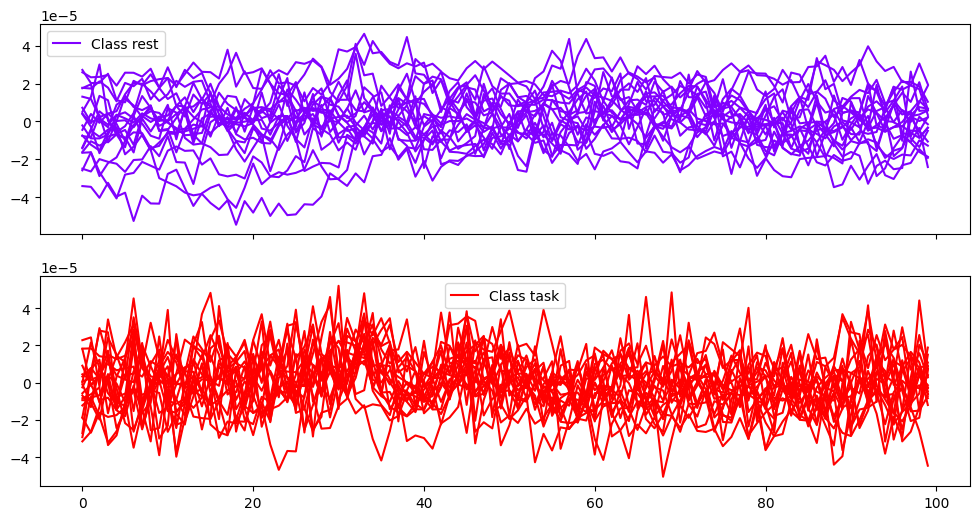

In [22]:
from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_c[:,0,:], y_train_c)

## Symbols Approximation Methods <a id="symbols"></a>
Two well known approaches to approximate a time series into segments are:

### SAX: Symbolic Aggregate approXimation <a id="sax"></a>

SAX [[1]](#references) first applies a Piecewise Aggregate Approximation (PAA) [[2]](#references) which is a dimensionality reduction technique that replaces each segment by its mean value.
This is followed by replacing each PAA value by its dictionary element associated to it using a lookup table.
This lookup table, referred to as dictionary, is defined using the Percent Point Function (PPF) of the Gaussian distribution.

<img src="./img/SAX.png" alt="sax"><i>

#### Transforming Time Series To Symbols with SAX <a id="sax-transform"></a>

In [5]:
from aeon.transformations.collection.dictionary_based import SAX

sax_transformer = SAX(n_segments=20, alphabet_size=500000, znormalized=True)
X_train_c_sax = sax_transformer.fit_transform(X_train_c)
print(X_train_c_sax.shape)
print(X_train_c_sax[0,0,:])

(40, 1, 20)
[250000 250001 250000 249999 249999 250000 250001 250003 249999 250001
 250000 249997 249997 249995 249995 249995 249997 249996 250000 249997]


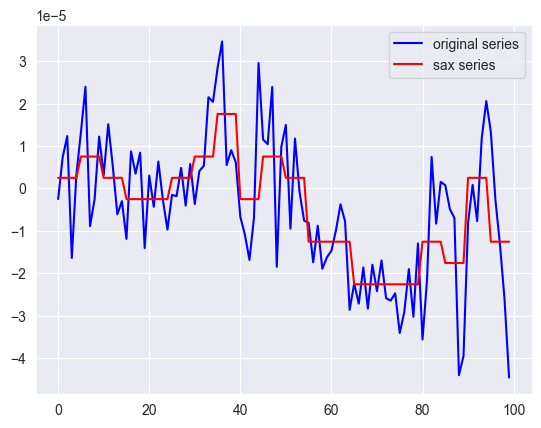

In [6]:
import matplotlib.pyplot as plt

X_train_c_inv_sax = sax_transformer.inverse_sax(X_train_c_sax, original_length=int(X_train_c.shape[-1]))

plt.plot(X_train_c[0,0,:], color='blue')
plt.plot(X_train_c_inv_sax[0,0,:], color='red')
plt.legend(["original series", "sax series"])

### SFA: Symbolic Fourier Approximation <a id="sfa"></a>

SFA [[3]](#references) operates by first normalizing the values in each window to achieve amplitude invariance. Next, dimensionality reduction is performed using a truncated Fourier transform, retaining only the first few coefficients, which helps filter out noise. The process continues with the derivation of discretization bins through Multiple Coefficient Binning (MCB), where the real and imaginary components of the Fourier coefficients are binned using either equi-depth or equi-width methods. Finally, each coefficient is discretized into a symbol from a fixed-size alphabet, enhancing robustness against noise.

<img src="./img/SFA.png" alt="sfa"><i>

#### Transforming Time Series To Symbols with SFA <a id="sfa-transform"></a>

In [23]:
from aeon.transformations.collection.dictionary_based import SFA

sfa_transformer = SFA(word_length=5)
X_train_c_sfa = sfa_transformer.fit(X_train_c).transform_words(X_train_c)
print(X_train_c_sfa)

[[[2 0 1 1 3]
  [0 0 0 1 1]
  [3 0 0 3 2]
  ...
  [3 0 2 1 1]
  [2 0 3 2 1]
  [2 0 0 2 2]]

 [[2 0 2 1 2]
  [0 0 0 1 1]
  [2 0 0 3 2]
  ...
  [3 0 0 2 2]
  [2 0 3 1 3]
  [2 0 0 3 3]]

 [[2 0 1 1 0]
  [0 0 0 2 2]
  [2 0 1 3 2]
  ...
  [3 0 0 2 3]
  [2 0 3 0 3]
  [2 0 1 3 2]]

 ...

 [[1 0 0 0 2]
  [3 0 0 3 2]
  [0 0 0 2 3]
  ...
  [3 0 1 3 2]
  [1 0 1 2 0]
  [2 0 3 1 2]]

 [[1 0 0 0 2]
  [2 0 0 3 2]
  [1 0 1 2 3]
  ...
  [3 0 1 3 1]
  [1 0 2 2 1]
  [2 0 3 0 2]]

 [[1 0 0 2 1]
  [2 0 2 3 2]
  [1 0 2 2 3]
  ...
  [3 0 1 3 2]
  [1 0 3 2 3]
  [2 0 1 0 2]]]


## Bag-of-SFA-Symbols (BOSS) <a id="boss"></a>

BOSS [[4]](#references) follows a similar process as described earlier, where each sliding window is converted into a word using the SFA method. A feature vector is then created by tallying the frequency of each word across all windows. Finally, a non-symmetric distance function is applied in conjunction with a 1-NN classifier to classify new instances.
<img src="./img/boss.png" alt="boss"><i>

In [8]:
from aeon.classification.dictionary_based import BOSSEnsemble
from sklearn.metrics import accuracy_score

boss = BOSSEnsemble()
boss.fit(X_train_c, y_train_c)
boss_preds = boss.predict(X_test_c)

print(accuracy_score(y_test_c, boss_preds))

0.6


## Multiple Representations Sequence Miner (MrSQM) <a id="mrsqm"></a>

MrSQM [[5,6]](#references) combines SFA and SAX symbolic transformations to discretize time series subseries into words and uses a logistic regression classifier. It uniquely employs a trie to store and rank frequent substrings, selecting features using either a supervised chi-squared test or an unsupervised random substring sampling method to avoid redundancy. Additionally, MrSQM adjusts the number of learned representations and the window size parameter based on the time series length, utilizing an exponential scale.

<img src="./img/sqm_arch.png" alt="mrsqm"><i>

In [71]:
from aeon.classification.shapelet_based import MrSQMClassifier

mrsqm = MrSQMClassifier()
mrsqm.fit(X_train_c, y_train_c)
mrsqm_preds = mrsqm.predict(X_test_c)
print(accuracy_score(y_test_c, mrsqm_preds))

/tmp/ipykernel_145129/1526384677.py:3: FutureWarning: Call to deprecated class MrSQMClassifier. (MrSQMClassifier will be moved to the dictionary_based package in version 0.11.0 at the request of the author.) -- Deprecated since version 0.10.0.
  mrsqm = MrSQMClassifier()


0.725


## WEASEL and WEASEL2 <a id="weasel"></a>

WEASEL v1.0 [[7]] is a time series classification pipeline that identifies and retains discriminative words by generating histograms of word counts across various window sizes and lengths. It uses a Chi-squared test for feature selection, discarding non-discriminative words, and then trains a linear Ridge classifier on the selected features. WEASEL also employs a supervised variation of SFA and an information-gain approach to optimize word creation and class separation.

WEASEL v2.0 [[8]] is an enhanced version of the original WEASEL classifier that reduces memory usage and improves accuracy by incorporating randomly parameterized SFA transformations and a dilated sliding window approach. This new approach extracts subseries with fixed gaps between values, applies a Fourier transform, and generates words using SFA. Additionally, it introduces a variance-based feature selection strategy to retain only the Fourier values with the highest variance, further optimizing performance.

<img src="./img/WEASEL.png" alt="weasel"><i>

In [72]:
from aeon.classification.dictionary_based import WEASEL, WEASEL_V2
from sklearn.metrics import accuracy_score

weasel = WEASEL()
weasel2 = WEASEL_V2()

weasel.fit(X_train_c, y_train_c)
weasel_preds = weasel.predict(X_test_c)

weasel2.fit(X_train_c, y_train_c)
weasel2_preds = weasel2.predict(X_test_c)

print("WASEL v1.0: ", accuracy_score(y_test_c, weasel_preds))
print("WASEL v2.0: ", accuracy_score(y_test_c, weasel2_preds))

/home/aismailfawaz/phd/venvs/aeon-venv-py310/lib/python3.10/site-packages/joblib/parallel.py:1362: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=99999' in Parallel but the 'timeout' parameter will not be used.
  warnings.warn(
/home/aismailfawaz/phd/venvs/aeon-venv-py310/lib/python3.10/site-packages/joblib/parallel.py:1362: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=99999' in Parallel but the 'timeout' parameter will not be used.
  warnings.warn(


WASEL v1.0:  0.725
WASEL v2.0:  0.525


## Performance on the UCR univariate classification datasets <a id='evaluation'></a>

Below we show the performance of the `BOSS`, `MrSQM`, `WEASEL` and `WEASEL2` models on the UCR TSC archive datasets [[9]](#references) using results from TSC bake off in 2024 [[10]](#references).

In [10]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = ["BOSS", "MrSQM", "WEASEL", "WEASEL_V2", "1NN-DTW"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 5)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

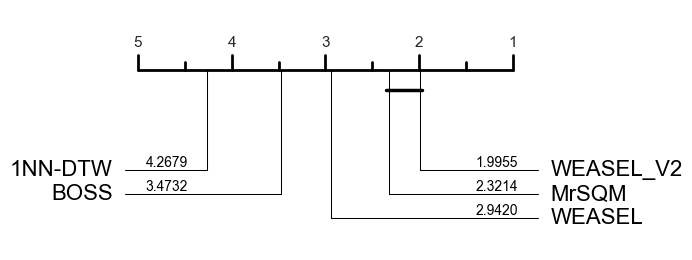

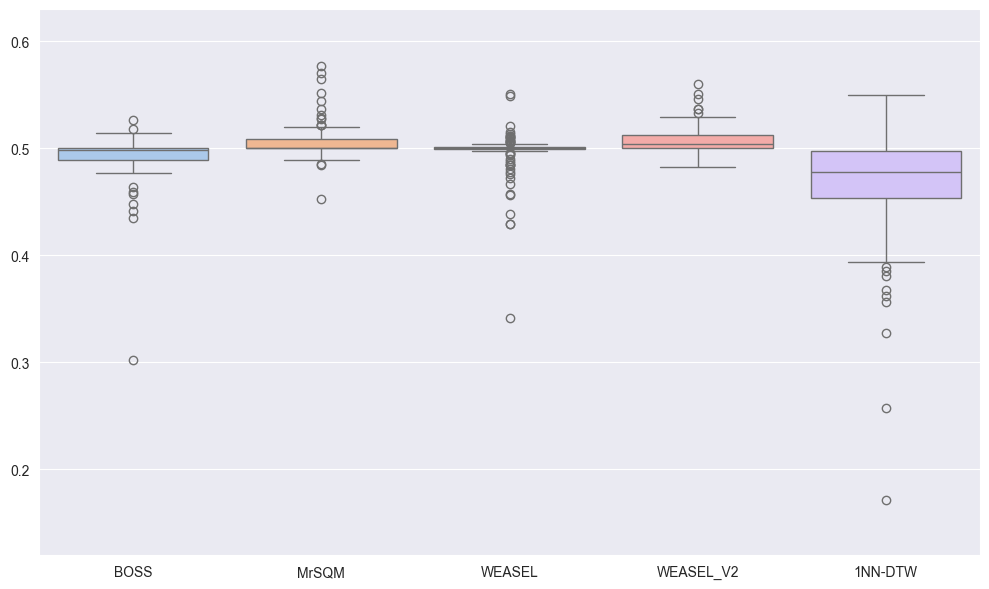

In [11]:
from aeon.visualisation import plot_critical_difference
from aeon.visualisation import plot_boxplot_median

plot_critical_difference(results, names)
plot_boxplot_median(results, names, plot_type="boxplot")

## References <a id="references"></a>

[1] E. Keogh & M. Pazzani. Scaling up dynamic time warping for datamining applications. SIGKDD 2000, pp. 285–289.

[2] J. Lin, E. Keogh, L. Wei, et al. Experiencing SAX: a novel symbolic representation of time series. Data Mining and Knowledge Discovery, 2007. vol. 15(107)

[3] Schäfer, Patrick, and Mikael Högqvist. ”SFA: a symbolic fourier approximation and index for similarity search in high
dimensional datasets.” Proceedings of the 15th international conference on extending database technology. 2012.

[4] Schäfer, Patrick. ”The BOSS is concerned with time series classification in the presence of noise.” Data Mining and
Knowledge Discovery 29 (2015): 1505-1530..

[5] Nguyen, Thach Le, and Georgiana Ifrim. ”Fast time series classification with random symbolic subsequences.”
Advanced Analytics and Learning on Temporal Data: 7th ECML PKDD Workshop, AALTD 2022

[6] Nguyen, Thach Le, and Georgiana Ifrim. ”MrSQM: Fast time series classification with symbolic representations.”
arXiv preprint arXiv:2109.01036 (2021).

[7] Schäfer, Patrick, and Ulf Leser. ”Fast and accurate time series classification with weasel.” Proceedings of the 2017
ACM on Conference on Information and Knowledge Management. 2017.

[8] Schäfer, Patrick, and Ulf Leser. ”WEASEL 2.0: a random dilated dictionary transform for fast, accurate and
memory constrained time series classification.” Machine Learning 112.12 (2023): 4763-4788

[9] Dau, Hoang Anh, et al. "The UCR time series archive." IEEE/CAA Journal of Automatica Sinica 6.6 (2019): 1293-1305.

[10] Middlehurst, Matthew, Patrick Schäfer, and Anthony Bagnall. "Bake off redux: a review and experimental evaluation of recent time series classification algorithms." Data Mining and Knowledge Discovery (2024): 1-74.